<a href="https://colab.research.google.com/github/Rocking-Priya/703-fall-coding-homeworks-2025/blob/main/Homework_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

## Due: Midnight on October 5th (with 2-hour grace period) and worth 85 points

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **LR schedules**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed / exponential / cosine), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model.

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [19]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [20]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        # print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [21]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 100,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )

    # Adjust callbacks based on lr_schedule type
    if isinstance(lr_schedule, float):  # Fixed learning rate
        cbs = [early_stop] + callbacks
    else:  # Learning rate schedule
        cbs = [early_stop] + callbacks
        # Note: ReduceLROnPlateau is generally not used with LR schedules
        # You might want to filter out ReduceLROnPlateau if it's in the passed callbacks list
        cbs = [cb for cb in cbs if not isinstance(cb, ReduceLROnPlateau)]


    if use_early_stopping:
        cbs=cbs # Already handled above based on lr_schedule type
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        # Find the epoch with the best validation accuracy if early stopping is not used
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]


    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  

In [22]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [23]:
# Reproducible load + preprocess for Intel Image Classification

IMG_SHAPE = (224,224,3)
IMG_SIZE = IMG_SHAPE[:2]

# -------------------------
# Loader (deterministic)
# -------------------------

def load_data_from_directory(directory, img_size=IMG_SIZE, class_names=None, preprocess="mobilenet_v2"):
    """
    Loads images as float32 and integer labels.
    If preprocess == 'mobilenet_v2', outputs are scaled to [-1, 1] as expected by MobileNetV2.
    Else, outputs are scaled to [0,1].
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img).astype("float32")  # values in [0,255]
            if preprocess == "mobilenet_v2":
                # Official Keras preprocessing: scales to [-1, 1]
                arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            else:
                arr = arr / 255.0  # your original behavior
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = np.stack(X).astype("float32")
    y = np.array(y, dtype="int32")
    return X, y, class_names


In [24]:
# Load full training set (preprocessed for MobileNetV2)
X_all, y_all, class_names = load_data_from_directory(
    train_dir, img_size=IMG_SIZE , preprocess="mobilenet_v2"
)

# 80/20 stratified split -> train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=random_seed,
    shuffle=True,
)

# Load test set using same class mapping + preprocessing
X_test, y_test, _ = load_data_from_directory(
    test_dir,
    img_size=IMG_SIZE,
    class_names=class_names
)

num_classes = len(class_names)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

print(f'num_classes: {num_classes}')
print('Class Names:', class_names)

Train: (11227, 224, 224, 3) (11227,)
Val:   (2807, 224, 224, 3) (2807,)
Test:  (3000, 224, 224, 3) (3000,)
num_classes: 6
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Examine The Dataset

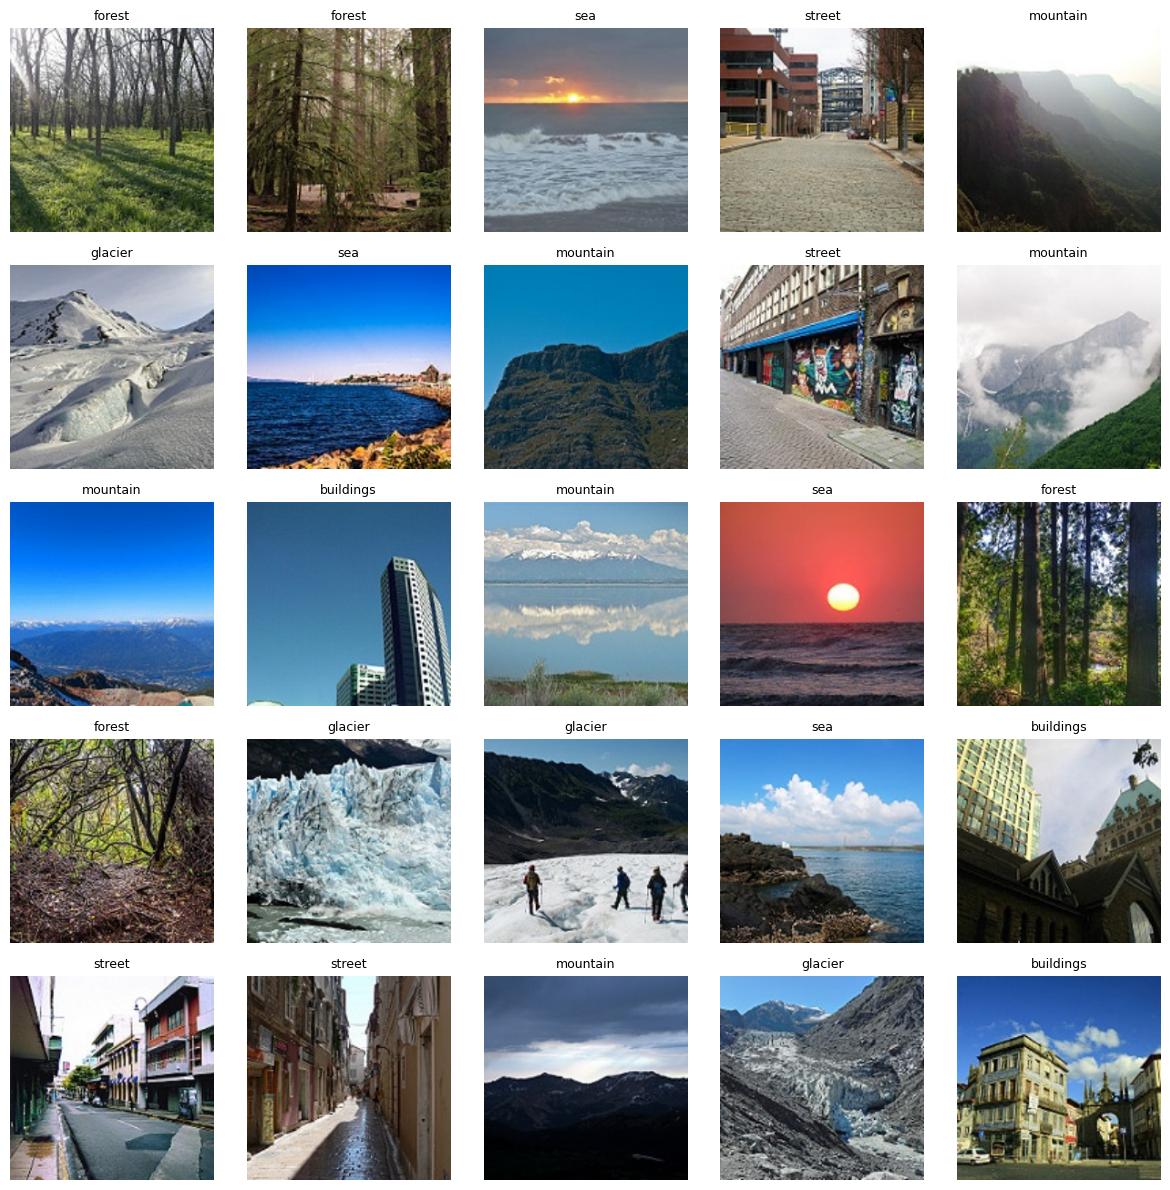

In [25]:
# pick 25 random, distinct indices
idx = np.random.choice(len(X_train), size=25, replace=False)

plt.figure(figsize=(12, 12))
for k, i in enumerate(idx, start=1):
    ax = plt.subplot(5, 5, k)
    ax.imshow((X_train[i] + 1.0) / 2.0)
    # if y_train is one-hot, take argmax; otherwise use the label directly
    label_idx = int(np.argmax(y_train[i])) if getattr(y_train, "ndim", 1) > 1 else int(y_train[i])
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Learning Rate Schedulers

In [26]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

In [27]:
# Both these must be input as lr_schedule in train_and_test(....   , lr_schedule=exp_decay, .... )

epochs = 100               # You'll need to adjust this to close to be close to the early stopping location
batch_size = 128

# Needed by LR schedulers

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`.

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).



In [28]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=IMG_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base

base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [29]:
# Ha, this is very long!

base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


Model Baseline



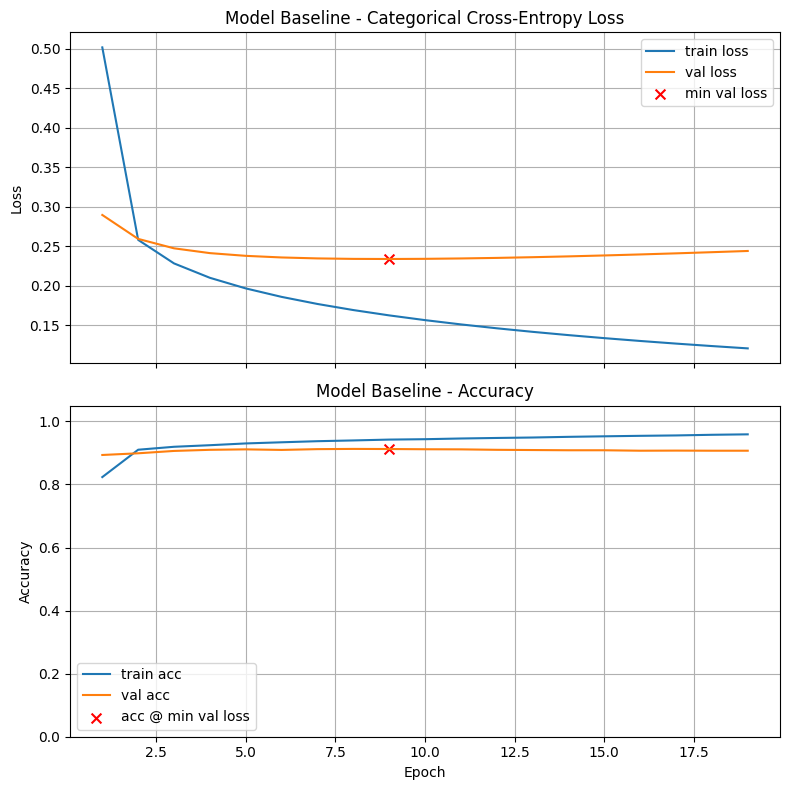

Final Training Loss:            0.1205
Final Training Accuracy:        0.9589
Final Validation Loss:          0.2438
Final Validation Accuracy:      0.9070
Validation Accuracy @ Min Loss: 0.9124

Test Loss: 0.2162
Test Accuracy: 0.9203

Validation-Test Gap (accuracy): 0.007971

Execution Time: 00:01:57


In [30]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()               # default: trainable=False

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')
])

train_and_test(model_baseline, title="Model Baseline")

## Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled()  # default: trainable=False
```


### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads and **give each experiment a unique descriptive title,** i.e., `title="Problem 1 Experiment 1"`
5. **Answer the graded questions.**

### Notes / Constraints

* The descriptive title will be used to compare results at the end of the notebook.
* With `pooling="avg"`, This backbone already applies Global Average Pooling and outputs a **1280-D** feature vector per image. **Do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.



Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.8049 - loss: 0.6897 - val_accuracy: 0.8864 - val_loss: 0.4263 - learning_rate: 0.0010
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9261 - loss: 0.3082 - val_accuracy: 0.9084 - val_loss: 0.3599 - learning_rate: 0.0010
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9418 - loss: 0.2577 - val_accuracy: 0.9131 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9503 - loss: 0.2309 - val_accuracy: 0.9177 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9591 - loss: 0.2064 - val_accuracy: 0.9084 - val_loss: 0.3509 - learning_rate: 0.0010
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9671 - loss: 0.1868 - val_accuracy: 0.9127 - val_loss: 0.3599 - learning_rate: 0.0010
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━

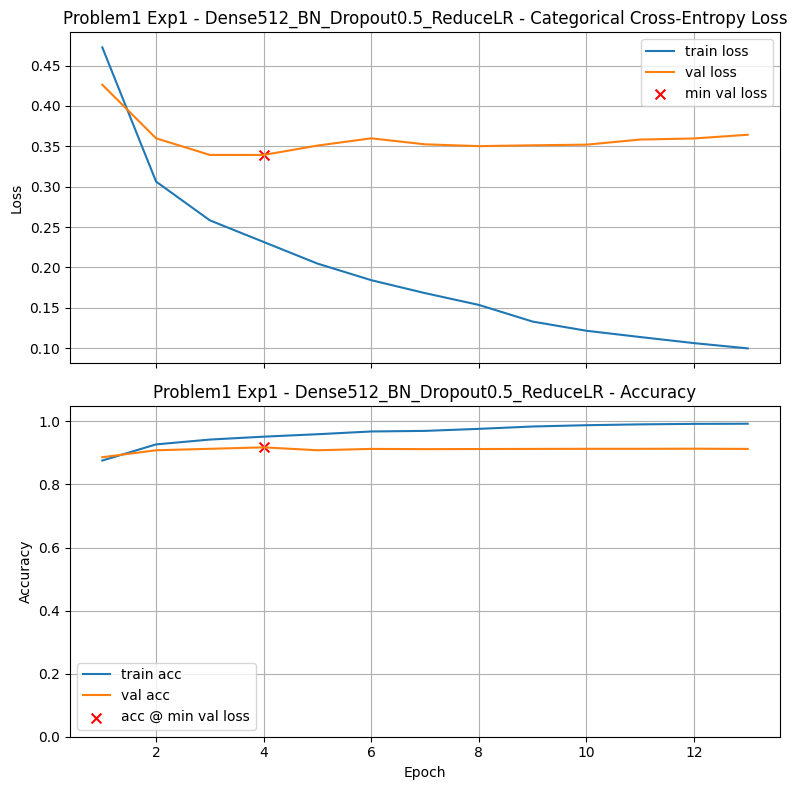

Final Training Loss:            0.0996
Final Training Accuracy:        0.9926
Final Validation Loss:          0.3643
Final Validation Accuracy:      0.9127
Validation Accuracy @ Min Loss: 0.9177

Test Loss: 0.3176
Test Accuracy: 0.9207

Validation-Test Gap (accuracy): 0.007592

Execution Time: 00:01:39

Problem1 Exp2 - Dense1024_512_ExpDecay

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 261ms/step - accuracy: 0.5789 - loss: 1.4512 - val_accuracy: 0.8814 - val_loss: 0.6382
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8690 - loss: 0.6710 - val_accuracy: 0.9027 - val_loss: 0.5737
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8832 - loss: 0.6268 - val_accuracy: 0.9067 - val_loss: 0.5556
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8993 - loss: 0.5801 - val_accuracy: 0.9088 - val_loss: 0.5478
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9082 - loss: 0.5587 - val_accuracy: 0.9099 - val_loss: 0.5410
Epoch 6/100
8

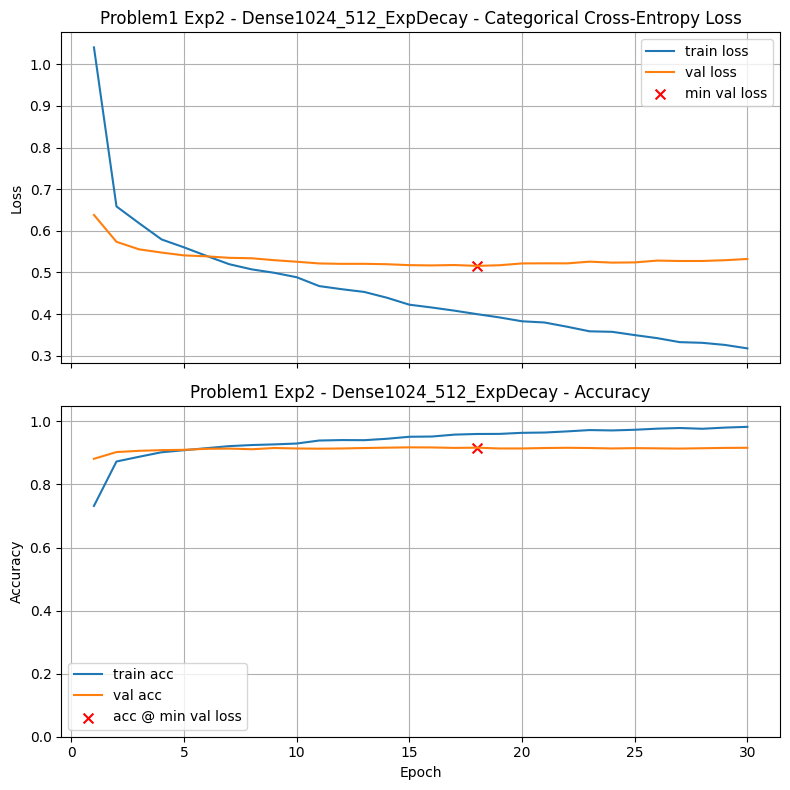

Final Training Loss:            0.3176
Final Training Accuracy:        0.9827
Final Validation Loss:          0.5324
Final Validation Accuracy:      0.9163
Validation Accuracy @ Min Loss: 0.9166

Test Loss: 0.4963
Test Accuracy: 0.9240

Validation-Test Gap (accuracy): 0.007363

Execution Time: 00:02:52

Problem1 Exp3 - Dense256_128_CosineDecay

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.4419 - loss: 1.5436 - val_accuracy: 0.8397 - val_loss: 0.5934
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8419 - loss: 0.5825 - val_accuracy: 0.8867 - val_loss: 0.4216
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8792 - loss: 0.4607 - val_accuracy: 0.9002 - val_loss: 0.3743
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8871 - loss: 0.4122 - val_accuracy: 0.9059 - val_loss: 0.3526
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9033 - loss: 0.3783 - val_accuracy: 0.9084 - val_loss: 0.3388
Epoch 6/100

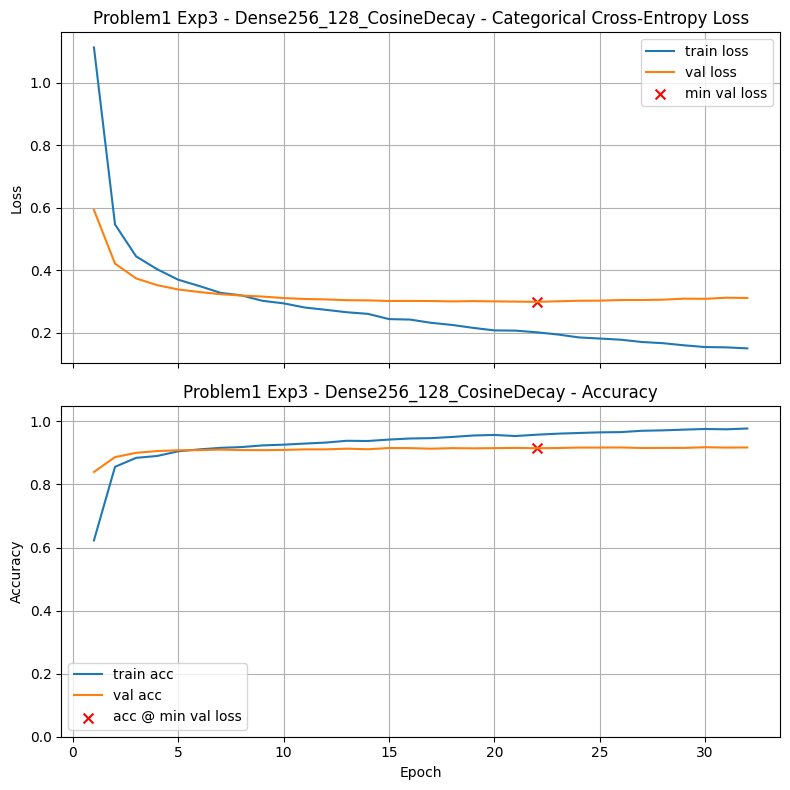

Final Training Loss:            0.1503
Final Training Accuracy:        0.9775
Final Validation Loss:          0.3116
Final Validation Accuracy:      0.9173
Validation Accuracy @ Min Loss: 0.9149

Test Loss: 0.2810
Test Accuracy: 0.9217

Validation-Test Gap (accuracy): 0.006811

Execution Time: 00:03:00

All experiments finished. Summary of validation accuracies (acc @ min val loss):
Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR	0.9177	4
Problem1 Exp2 - Dense1024_512_ExpDecay  	0.9166	18
Problem1 Exp3 - Dense256_128_CosineDecay	0.9149	22
Model Baseline                          	0.9124	9

Best model: Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR with validation accuracy = 0.9177 (epoch 4)

a1 = 0.9177   # assign this value to the variable a1 for the graded cell


In [31]:
# Your code here; add as many cells as you need


# Experiment 1: Simple head
title1 = "Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR"
base1 = make_base_model_pooled()   # fresh frozen backbone (trainable=False)
model_exp1 = models.Sequential([
    base1,
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Train (fixed LR, ReduceLROnPlateau enabled)
hist1 = train_and_test(
    model_exp1,
    epochs=epochs,
    lr_schedule=1e-3,          # fixed learning rate for Adam
    optimizer="Adam",
    title=title1,
    batch_size=batch_size,
    callbacks=[reduce_lr], # Include reduce_lr here
    use_early_stopping=True,
    patience=10,
    min_delta=1e-4,
    verbose=1,
    return_history=True
)


# Experiment 2: Deeper head (more capacity) + ExponentialDecay LR schedule
title2 = "Problem1 Exp2 - Dense1024_512_ExpDecay"
base2 = make_base_model_pooled()
model_exp2 = models.Sequential([
    base2,
    Dense(1024, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

hist2 = train_and_test(
    model_exp2,
    epochs=epochs,
    lr_schedule=exp_decay,     # ExponentialDecay schedule (defined earlier)
    optimizer="Adam",
    title=title2,
    batch_size=batch_size,
    callbacks=[], # Exclude reduce_lr here as we use a schedule
    use_early_stopping=True,
    patience=12,
    min_delta=1e-4,
    verbose=1,
    return_history=True
)


# Experiment 3: Modest head with CosineDecay schedule + lighter dropout
title3 = "Problem1 Exp3 - Dense256_128_CosineDecay"
base3 = make_base_model_pooled()
model_exp3 = models.Sequential([
    base3,
    Dense(256, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(128, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

hist3 = train_and_test(
    model_exp3,
    epochs=epochs,
    lr_schedule=cosine_decay,  # CosineDecay defined earlier
    optimizer="Adam",
    title=title3,
    batch_size=batch_size,
    callbacks=[], # Exclude reduce_lr here as we use a schedule
    use_early_stopping=True,
    patience=10,
    min_delta=1e-4,
    verbose=1,
    return_history=True
)


# print a tidy results table and set a1 automatically
print("\nAll experiments finished. Summary of validation accuracies (acc @ min val loss):")
print_results()

# Choose the best experiment by validation accuracy (as stored in `results`)
best_title, (best_acc, best_epoch) = max(results.items(), key=lambda kv: kv[1][0])
print(f"\nBest model: {best_title} with validation accuracy = {best_acc:.4f} (epoch {best_epoch})")

# Set a1 as required by the assignment (automatic)
a1 = float(best_acc)
print(f"\na1 = {a1:.4f}   # assign this value to the variable a1 for the graded cell")

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.


**Your answer here:**




The best-performing head was Problem1 Exp1 — Dense512_BN_Dropout0.5_ReduceLR, which achieved validation accuracy 0.9177. This mid-sized head likely outperformed the larger and smaller heads because it provided enough capacity to linearly combine the 1280-D MobileNetV2 features while BatchNormalization, L2 regularization, and 50% dropout prevented overfitting. The use of ReduceLROnPlateau (which lowered the learning rate when validation loss stalled) helped stabilize training and find a better minima than a fixed or purely decaying schedule alone. Overall, when the backbone is frozen a moderately sized, well-regularized head plus adaptive LR control is more effective than simply increasing head depth or removing regularization.

In [44]:
# Set a1 to the validation accuracy found by your best model for this problem.

a1 =  0.9177             # Replace 0.0 with your answer

In [45]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a1 = {a1}')


a1 = 0.9177


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—don’t add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **unfrozen**. Vary:

   * **Head choice** (pick one from Problem 1).
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**.
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (can combine with a fixed LR).
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 2 Experiment 1"`
3. **Answer the graded questions.**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


P2 Exp1 - Dense512_BN_Dropout0.5_ft_fixedLR

Epoch 1/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 120s 703ms/step - accuracy: 0.4206 - loss: 1.8424 - val_accuracy: 0.7699 - val_loss: 0.7779 - learning_rate: 3.0000e-05
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8550 - loss: 0.5335 - val_accuracy: 0.8030 - val_loss: 0.6859 - learning_rate: 3.0000e-05
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9062 - loss: 0.3815 - val_accuracy: 0.8233 - val_loss: 0.6381 - learning_rate: 3.0000e-05
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9337 - loss: 0.3004 - val_accuracy: 0.8301 - val_loss: 0.6183 - learning_rate: 3.0000e-05
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9486 - loss: 0.2569 - val_accuracy: 0.8436 - val_loss: 0.5735 - learning_rate: 3.0000e-05
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9617 - loss: 0.2168 - val_accuracy: 0.8514 - val_loss: 0.5586 - learning_rate: 3.0000e-05
Epoch 7/60
88/88 ━━━━

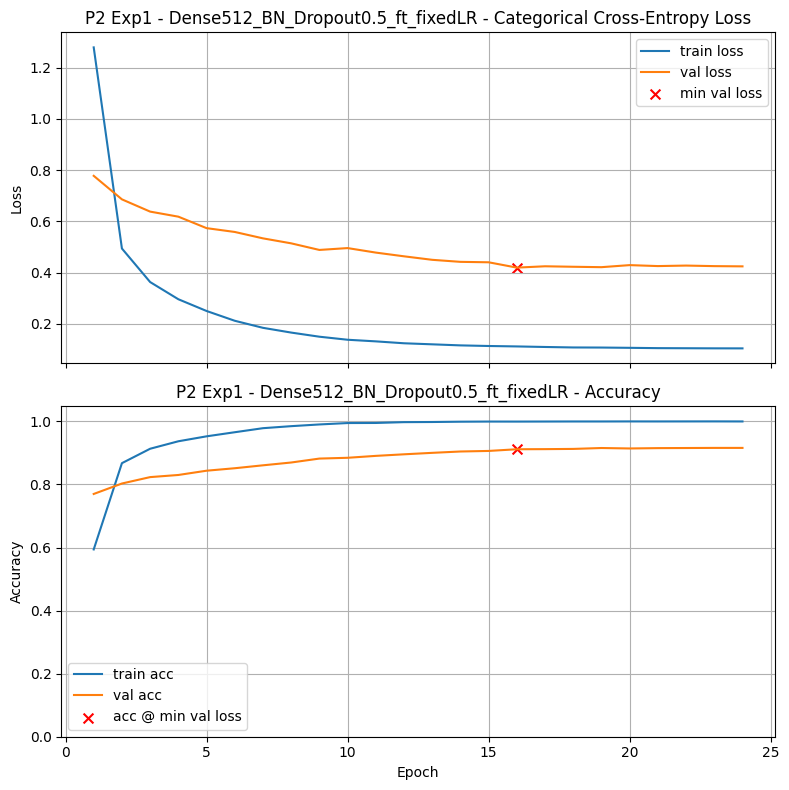

Final Training Loss:            0.1038
Final Training Accuracy:        0.9998
Final Validation Loss:          0.4242
Final Validation Accuracy:      0.9159
Validation Accuracy @ Min Loss: 0.9116

Test Loss: 0.4359
Test Accuracy: 0.9077

Validation-Test Gap (accuracy): 0.003983

Execution Time: 00:05:19

P2 Exp2 - Dense1024_512_ExpDecay_ft

Epoch 1/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 94s 504ms/step - accuracy: 0.3237 - loss: 2.1800 - val_accuracy: 0.7734 - val_loss: 0.9623
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7915 - loss: 0.9074 - val_accuracy: 0.7952 - val_loss: 0.9092
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8753 - loss: 0.6897 - val_accuracy: 0.8023 - val_loss: 0.9111
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9075 - loss: 0.5910 - val_accuracy: 0.8158 - val_loss: 0.8773
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9232 - loss: 0.5376 - val_accuracy: 0.8233 - val_loss: 0.8693
Epoch 6/60
88/88 ━━━━

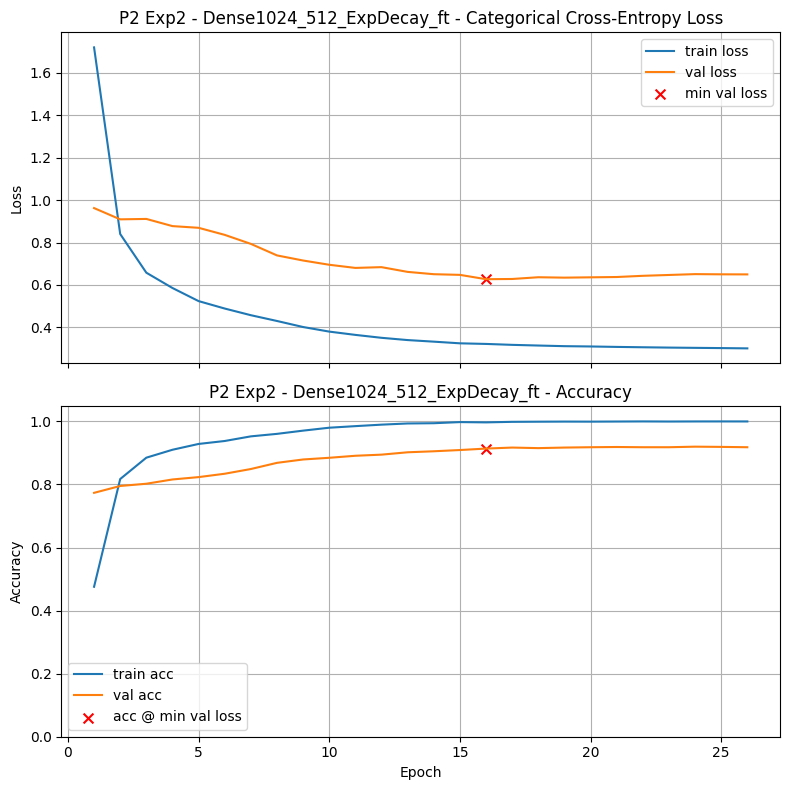

Final Training Loss:            0.3010
Final Training Accuracy:        0.9998
Final Validation Loss:          0.6497
Final Validation Accuracy:      0.9181
Validation Accuracy @ Min Loss: 0.9138

Test Loss: 0.6216
Test Accuracy: 0.9143

Validation-Test Gap (accuracy): 0.000546

Execution Time: 00:05:09

P2 Exp3 - Dense256_128_CosineDecay_ft

Epoch 1/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 94s 510ms/step - accuracy: 0.3963 - loss: 1.6424 - val_accuracy: 0.7439 - val_loss: 0.8456
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8352 - loss: 0.6404 - val_accuracy: 0.7877 - val_loss: 0.7414
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8965 - loss: 0.4591 - val_accuracy: 0.7969 - val_loss: 0.7070
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9232 - loss: 0.3701 - val_accuracy: 0.8048 - val_loss: 0.6651
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9422 - loss: 0.3093 - val_accuracy: 0.8187 - val_loss: 0.6009
Epoch 6/60
88/88 ━━

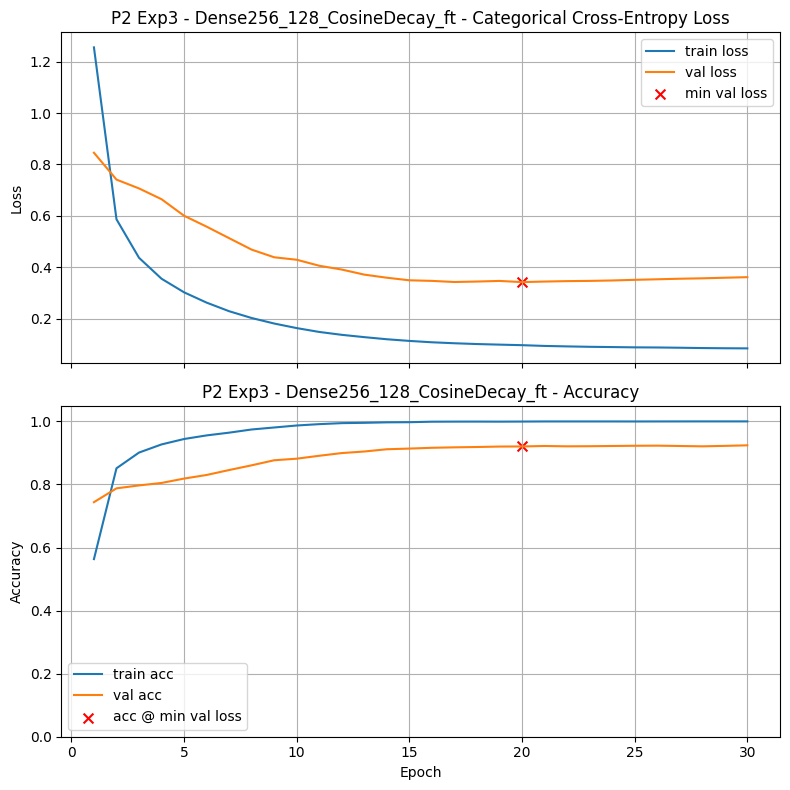

Final Training Loss:            0.0857
Final Training Accuracy:        1.0000
Final Validation Loss:          0.3623
Final Validation Accuracy:      0.9241
Validation Accuracy @ Min Loss: 0.9206

Test Loss: 0.3436
Test Accuracy: 0.9160

Validation-Test Gap (accuracy): 0.004556

Execution Time: 00:05:41

Problem 2 experiments finished. Summary (validation accuracy @ min val loss):
P2 Exp3 - Dense256_128_CosineDecay_ft   	0.9206	20
Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR	0.9177	4
Problem1 Exp2 - Dense1024_512_ExpDecay  	0.9166	18
Problem1 Exp3 - Dense256_128_CosineDecay	0.9149	22
P2 Exp2 - Dense1024_512_ExpDecay_ft     	0.9138	16
Model Baseline                          	0.9124	9
P2 Exp1 - Dense512_BN_Dropout0.5_ft_fixedLR	0.9116	16

Best overall (across all experiments run so far): P2 Exp3 - Dense256_128_CosineDecay_ft  val_acc = 0.9206  (epoch 20)

Best Problem 2 model: P2 Exp3 - Dense256_128_CosineDecay_ft  val_acc = 0.9206  (epoch 20)

a2 = 0.9206   # copy this into the graded

In [34]:
# Your code here; add as many cells as you need
#

# --- 1) Fine-tuning hyperparameters
fine_tune_epochs = 60
ft_batch_size = batch_size

# compute steps/total steps for schedules
steps_per_epoch_ft = int(np.ceil(len(X_train) / ft_batch_size))
total_steps_ft = fine_tune_epochs * steps_per_epoch_ft

# --- 2) Fine-tuning LR schedules (smaller initial LR than head-only training) ---
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay

ft_initial_lr = 3e-5

ft_exp_decay = ExponentialDecay(
    initial_learning_rate=ft_initial_lr,
    decay_steps=total_steps_ft,
    decay_rate=0.98,
    staircase=False
)

ft_cosine_decay = CosineDecay(
    initial_learning_rate=ft_initial_lr,
    decay_steps=total_steps_ft,
    alpha=0.0
)

# Optionally create a ReduceLROnPlateau for fine-tuning (smaller patience than head-only)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr_ft = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_delta=1e-5,
    cooldown=0, min_lr=1e-8, verbose=1
)

# --- 3) Experiment 1: From Problem1 Exp1 head, backbone unfrozen, fixed small LR ---
title_p2_e1 = "P2 Exp1 - Dense512_BN_Dropout0.5_ft_fixedLR"

# ALWAYS create a fresh backbone instance with trainable=True
base_p2_e1 = make_base_model_pooled(trainable=True)

# Build model: same head as Problem1 Exp1 but now backbone is trainable
model_p2_e1 = models.Sequential([
    base_p2_e1,
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Train: fixed small LR (ft_initial_lr), with ReduceLROnPlateau, and tighter early stopping
hist_p2_e1 = train_and_test(
    model_p2_e1,
    epochs=fine_tune_epochs,
    lr_schedule=ft_initial_lr,   # fixed small LR for Adam
    optimizer="Adam",
    title=title_p2_e1,
    batch_size=ft_batch_size,
    callbacks=[reduce_lr_ft],    # we keep this to drop LR if val_loss stalls
    use_early_stopping=True,
    patience=8,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)


# --- 4) Experiment 2: From Problem1 Exp2 head, backbone unfrozen, ExponentialDecay ---
title_p2_e2 = "P2 Exp2 - Dense1024_512_ExpDecay_ft"

base_p2_e2 = make_base_model_pooled(trainable=True)
model_p2_e2 = models.Sequential([
    base_p2_e2,
    Dense(1024, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

hist_p2_e2 = train_and_test(
    model_p2_e2,
    epochs=fine_tune_epochs,
    lr_schedule=ft_exp_decay,   # decaying lr starting at ft_initial_lr
    optimizer="Adam",
    title=title_p2_e2,
    batch_size=ft_batch_size,
    callbacks=[reduce_lr_ft],
    use_early_stopping=True,
    patience=10,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)


# --- 5) Experiment 3: From Problem1 Exp3 head, backbone unfrozen, CosineDecay, no ReduceLROnPlateau ---
title_p2_e3 = "P2 Exp3 - Dense256_128_CosineDecay_ft"

base_p2_e3 = make_base_model_pooled(trainable=True)
model_p2_e3 = models.Sequential([
    base_p2_e3,
    Dense(256, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(128, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

hist_p2_e3 = train_and_test(
    model_p2_e3,
    epochs=fine_tune_epochs,
    lr_schedule=ft_cosine_decay,  # cosine schedule starting at ft_initial_lr
    optimizer="Adam",
    title=title_p2_e3,
    batch_size=ft_batch_size,
    callbacks=[],                # no ReduceLROnPlateau here (we rely on cosine schedule)
    use_early_stopping=True,
    patience=10,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)


# --- 6) Summarize results and set a2 automatically ---
print("\nProblem 2 experiments finished. Summary (validation accuracy @ min val loss):")
print_results()

# Choose the best experiment by the validation accuracy (acc @ min val loss)
best_title_p2, (best_acc_p2, best_epoch_p2) = max(results.items(), key=lambda kv: kv[1][0])
print(f"\nBest overall (across all experiments run so far): {best_title_p2}  val_acc = {best_acc_p2:.4f}  (epoch {best_epoch_p2})")


p2_results = {k:v for k,v in results.items() if k.startswith("P2")}
if len(p2_results) > 0:
    best_title_p2, (best_acc_p2, best_epoch_p2) = max(p2_results.items(), key=lambda kv: kv[1][0])
    a2 = float(best_acc_p2)
    print(f"\nBest Problem 2 model: {best_title_p2}  val_acc = {a2:.4f}  (epoch {best_epoch_p2})")
else:
    # Fallback: use global best if no P2 entries exist
    a2 = float(best_acc_p2)
    print(f"\nNo P2-prefixed results found in `results`. Using global best: {best_title_p2} with val_acc = {a2:.4f}")

# Print a2 exactly as the assignment expects
print(f"\na2 = {a2:.4f}   # copy this into the graded cell if needed")


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your answer here:**





The best-performing setup was P2 Exp3 — Dense256_128_CosineDecay_ft, which achieved a validation accuracy of 0.9206. I chose three experiments to explore trade-offs between head capacity and fine-tuning behaviour: a mid-sized head with fixed small LR, a deeper head with exponential decay, and a slim head with cosine decay. The slim head likely outperformed the others because, once the backbone was unfrozen, a smaller, well-regularized head reduced overfitting while the CosineDecay schedule provided smooth, gradual LR reduction that kept training stable and allowed finer feature adaptation. This suggests that when fine-tuning the entire backbone, conservative learning rates and a compact, regularized head often yield better generalization than simply adding head depth.

In [46]:
# Set a2 to the validation accuracy found by your best model for this problem.

a2 = 0.9206             # Replace 0.0 with your answer

In [47]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a2 = {a2:.4f}')

a2 = 0.9206


## Problem Three: Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$** layers to fine-tune. (In Problem 4 you’ll try unfreezing the top **K blocks** instead.)

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model unfreeze the top $N$ layers using the following approach:

    N=20
    model = make_base_model_pooled()
    base_model.trainable = True
    for layer in base_model.layers[:-N]:
        layer.trainable = False

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen.** Vary hyperparameters such as:
   * $N\in \{20,40,60, 80\}$
   * **Head choice** (pick one from Problem 1).
   * **Learning rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay** (your choice of settings).
   * **Early Stopping** settings.
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (you can combine it with a fixed LR).
2. **Run and compare** the three experimentsand **give each experiment a unique descriptive title,** i.e., `title="Problem 3 Experiment 1"`
3. **Answer the graded questions**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


P3 Exp1 - N20_Dense512_fixedLR

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.4312 - loss: 1.6477 - val_accuracy: 0.7538 - val_loss: 0.7798 - learning_rate: 2.0000e-05
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8141 - loss: 0.6321 - val_accuracy: 0.8019 - val_loss: 0.6327 - learning_rate: 2.0000e-05
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8736 - loss: 0.4751 - val_accuracy: 0.8247 - val_loss: 0.5796 - learning_rate: 2.0000e-05
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8885 - loss: 0.4302 - val_accuracy: 0.8554 - val_loss: 0.5163 - learning_rate: 2.0000e-05
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9045 - loss: 0.3764 - val_accuracy: 0.8696 - val_loss: 0.4922 - learning_rate: 2.0000e-05
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9160 - loss: 0.3469 - val_accuracy: 0.8853 - val_loss: 0.4546 - learning_rate: 2.0000e-05
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━

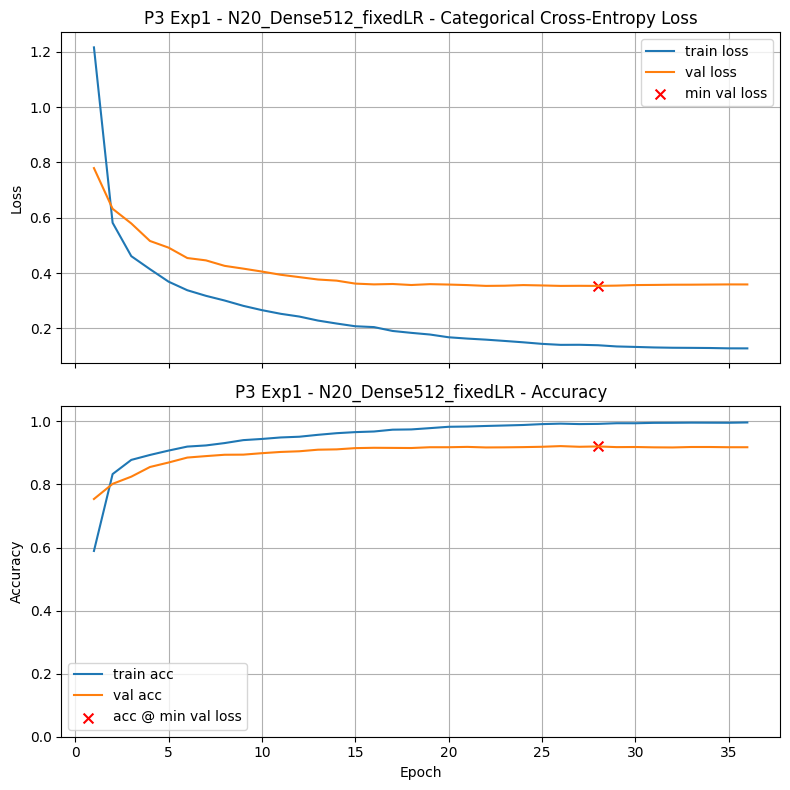

Final Training Loss:            0.1280
Final Training Accuracy:        0.9966
Final Validation Loss:          0.3591
Final Validation Accuracy:      0.9181
Validation Accuracy @ Min Loss: 0.9206

Test Loss: 0.3388
Test Accuracy: 0.9203

Validation-Test Gap (accuracy): 0.000222

Execution Time: 00:03:30

P3 Exp2 - N40_Deep_ExpDecay

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 314ms/step - accuracy: 0.2857 - loss: 2.2517 - val_accuracy: 0.6630 - val_loss: 1.2036
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7048 - loss: 1.1253 - val_accuracy: 0.7567 - val_loss: 0.9267
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8236 - loss: 0.8236 - val_accuracy: 0.8026 - val_loss: 0.8242
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8715 - loss: 0.6960 - val_accuracy: 0.8226 - val_loss: 0.7893
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8884 - loss: 0.6401 - val_accuracy: 0.8404 - val_loss: 0.7542
Epoch 6/50
88/88 ━━━━━━━━━━━━

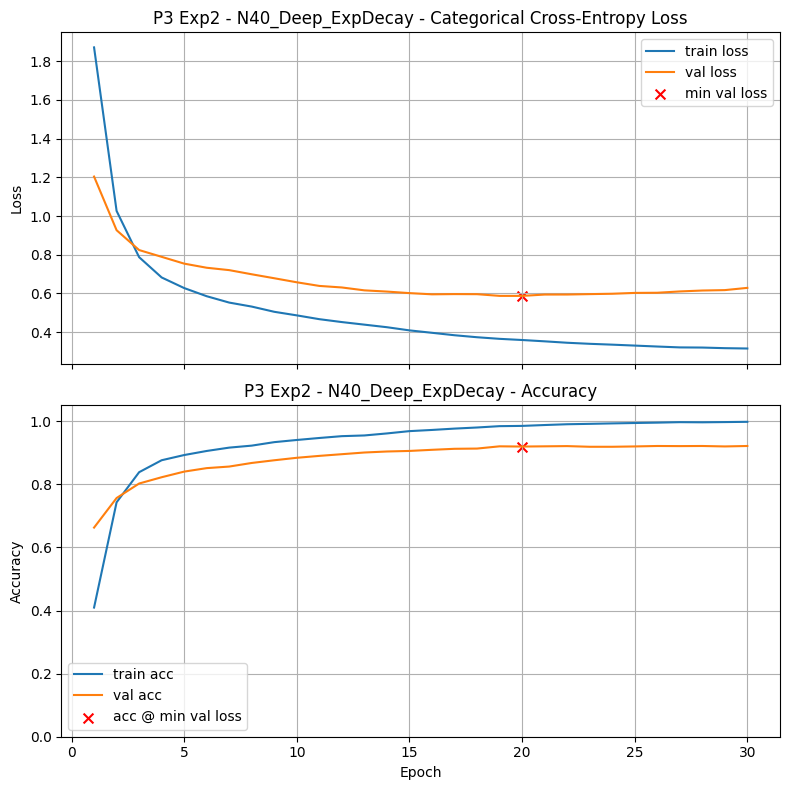

Final Training Loss:            0.3160
Final Training Accuracy:        0.9982
Final Validation Loss:          0.6290
Final Validation Accuracy:      0.9216
Validation Accuracy @ Min Loss: 0.9198

Test Loss: 0.5607
Test Accuracy: 0.9173

Validation-Test Gap (accuracy): 0.002510

Execution Time: 00:03:20

P3 Exp3 - N60_Deep_fixedLR

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 54s 337ms/step - accuracy: 0.3229 - loss: 2.0907 - val_accuracy: 0.7182 - val_loss: 1.0433 - learning_rate: 2.0000e-05
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7472 - loss: 1.0151 - val_accuracy: 0.7763 - val_loss: 0.9056 - learning_rate: 2.0000e-05
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8439 - loss: 0.7673 - val_accuracy: 0.7980 - val_loss: 0.8709 - learning_rate: 2.0000e-05
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8777 - loss: 0.6553 - val_accuracy: 0.8137 - val_loss: 0.8371 - learning_rate: 2.0000e-05
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms

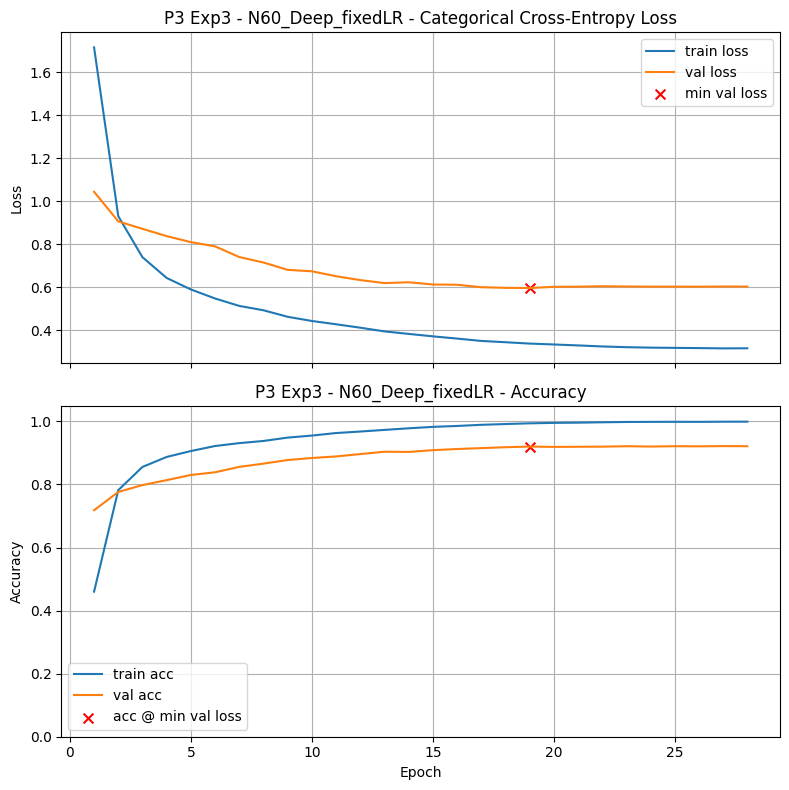

Final Training Loss:            0.3154
Final Training Accuracy:        0.9991
Final Validation Loss:          0.6024
Final Validation Accuracy:      0.9213
Validation Accuracy @ Min Loss: 0.9202

Test Loss: 0.5791
Test Accuracy: 0.9223

Validation-Test Gap (accuracy): 0.002134

Execution Time: 00:03:26

P3 Exp4 - N80_Slim_CosineDecay

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 359ms/step - accuracy: 0.3499 - loss: 1.7403 - val_accuracy: 0.7086 - val_loss: 0.9137
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7420 - loss: 0.8576 - val_accuracy: 0.7887 - val_loss: 0.6586
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8502 - loss: 0.5932 - val_accuracy: 0.8094 - val_loss: 0.5994
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8880 - loss: 0.4853 - val_accuracy: 0.8215 - val_loss: 0.5665
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9124 - loss: 0.4075 - val_accuracy: 0.8347 - val_loss: 0.5306
Epoch 6/50
88/88 ━━━━━━━━━

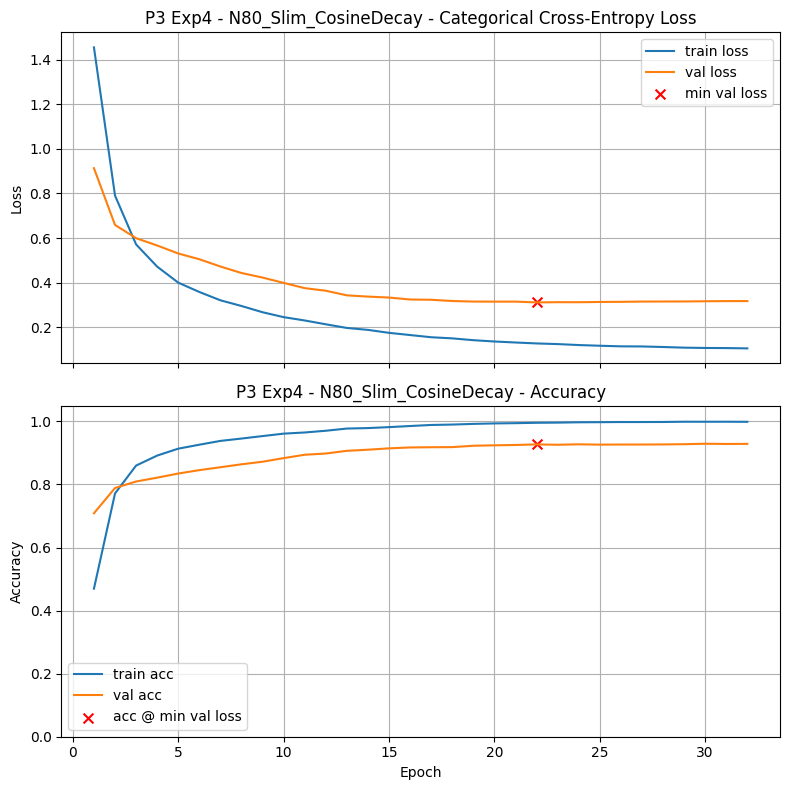

Final Training Loss:            0.1046
Final Training Accuracy:        0.9987
Final Validation Loss:          0.3170
Final Validation Accuracy:      0.9287
Validation Accuracy @ Min Loss: 0.9270

Test Loss: 0.3088
Test Accuracy: 0.9233

Validation-Test Gap (accuracy): 0.003635

Execution Time: 00:04:05

Problem 3 experiments finished. Summary (validation accuracy @ min val loss):
P3 Exp4 - N80_Slim_CosineDecay          	0.9270	22
P2 Exp3 - Dense256_128_CosineDecay_ft   	0.9206	20
P3 Exp1 - N20_Dense512_fixedLR          	0.9206	28
P3 Exp3 - N60_Deep_fixedLR              	0.9202	19
P3 Exp2 - N40_Deep_ExpDecay             	0.9198	20
Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR	0.9177	4
Problem1 Exp2 - Dense1024_512_ExpDecay  	0.9166	18
Problem1 Exp3 - Dense256_128_CosineDecay	0.9149	22
P2 Exp2 - Dense1024_512_ExpDecay_ft     	0.9138	16
Model Baseline                          	0.9124	9
P2 Exp1 - Dense512_BN_Dropout0.5_ft_fixedLR	0.9116	16

Best Problem 3 model: P3 Exp4 - N80_Slim_Cosine

In [37]:
# Your code here; add as many cells as you need


from math import ceil
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ---------- Hyperparameters ----------
p3_epochs = 50              # epochs budget; EarlyStopping will usually stop earlier
p3_batch_size = batch_size  # reuse earlier batch_size; if OOM set to 64 or 32
p3_initial_lr = 2e-5        # small LR (typical for partial fine-tuning)

# compute steps for LR schedules
steps_per_epoch_p3 = int(ceil(len(X_train) / p3_batch_size))
total_steps_p3 = p3_epochs * steps_per_epoch_p3

# LR schedules for experiments
p3_exp_decay = ExponentialDecay(
    initial_learning_rate=p3_initial_lr,
    decay_steps=total_steps_p3,
    decay_rate=0.98,
    staircase=False
)

p3_cosine_decay = CosineDecay(
    initial_learning_rate=p3_initial_lr,
    decay_steps=total_steps_p3,
    alpha=0.0
)

# ReduceLROnPlateau tuned for smaller patience since we're fine-tuning fewer layers
reduce_lr_p3 = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_delta=1e-5,
    cooldown=0, min_lr=1e-8, verbose=1
)

# Helper to unfreeze last N layers of a base model.
def make_partial_frozen_base(N):
    """
    Returns a MobileNetV2 base (include_top=False, pooling='avg') with
    the last N layers trainable and the rest frozen.
    """
    base = make_base_model_pooled(trainable=True)   # fresh instance, trainable True
    if N < len(base.layers):
        for layer in base.layers[:-N]:
            layer.trainable = False
        for layer in base.layers[-N:]:
            layer.trainable = True
    else:
        for layer in base.layers:
            layer.trainable = True
    return base

# ---------- EXPERIMENT 1 ----------
# N = 20, head = Dense512 (Problem1 Exp1), fixed small LR + ReduceLROnPlateau
title_p3_e1 = "P3 Exp1 - N20_Dense512_fixedLR"
N1 = 20

base_p3_e1 = make_partial_frozen_base(N1)
model_p3_e1 = models.Sequential([
    base_p3_e1,
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

hist_p3_e1 = train_and_test(
    model_p3_e1,
    epochs=p3_epochs,
    lr_schedule=p3_initial_lr,    # fixed LR for Adam
    optimizer="Adam",
    title=title_p3_e1,
    batch_size=p3_batch_size,
    callbacks=[reduce_lr_p3],
    use_early_stopping=True,
    patience=8,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)

# ---------- EXPERIMENT 2 ----------
# N = 40, head = Dense1024->512 (Problem1 Exp2), ExponentialDecay schedule
title_p3_e2 = "P3 Exp2 - N40_Deep_ExpDecay"
N2 = 40

base_p3_e2 = make_partial_frozen_base(N2)
model_p3_e2 = models.Sequential([
    base_p3_e2,
    Dense(1024, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

hist_p3_e2 = train_and_test(
    model_p3_e2,
    epochs=p3_epochs,
    lr_schedule=p3_exp_decay,   # decaying LR from p3_initial_lr
    optimizer="Adam",
    title=title_p3_e2,
    batch_size=p3_batch_size,
    callbacks=[reduce_lr_p3],
    use_early_stopping=True,
    patience=10,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)

# ---------- EXPERIMENT 3 ----------
# N = 60, head = Dense1024->512 (variant), fixed small LR (we keep a 2nd deep test for N=60)
title_p3_e3 = "P3 Exp3 - N60_Deep_fixedLR"
N3 = 60

base_p3_e3 = make_partial_frozen_base(N3)
model_p3_e3 = models.Sequential([
    base_p3_e3,
    Dense(1024, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.45),
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.35),
    Dense(num_classes, activation='softmax')
])

hist_p3_e3 = train_and_test(
    model_p3_e3,
    epochs=p3_epochs,
    lr_schedule=p3_initial_lr,   # fixed LR for Adam
    optimizer="Adam",
    title=title_p3_e3,
    batch_size=p3_batch_size,
    callbacks=[reduce_lr_p3],
    use_early_stopping=True,
    patience=9,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)

# ---------- EXPERIMENT 4 ----------
# N = 80, head = Dense256->128 (Problem1 Exp3), CosineDecay schedule, lighter dropout
title_p3_e4 = "P3 Exp4 - N80_Slim_CosineDecay"
N4 = 80

base_p3_e4 = make_partial_frozen_base(N4)
model_p3_e4 = models.Sequential([
    base_p3_e4,
    Dense(256, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(128, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

hist_p3_e4 = train_and_test(
    model_p3_e4,
    epochs=p3_epochs,
    lr_schedule=p3_cosine_decay,
    optimizer="Adam",
    title=title_p3_e4,
    batch_size=p3_batch_size,
    callbacks=[],   # rely on cosine schedule + early stopping
    use_early_stopping=True,
    patience=10,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)

# ---------- Summarize & pick best P3 ----------
print("\nProblem 3 experiments finished. Summary (validation accuracy @ min val loss):")
print_results()

# Filter only Problem 3 results (prefix "P3 ") so we pick best among these experiments
p3_results = {k:v for k,v in results.items() if k.startswith("P3")}
if len(p3_results) == 0:
    print("\nNo P3 results found in `results`. Did the cell run without errors?")
    best_title_all, (best_acc_all, best_ep_all) = max(results.items(), key=lambda kv: kv[1][0])
    a3 = float(best_acc_all)
    print(f"Fallback: using global best {best_title_all} with val_acc = {a3:.4f}")
else:
    best_title_p3, (best_acc_p3, best_ep_p3) = max(p3_results.items(), key=lambda kv: kv[1][0])
    a3 = float(best_acc_p3)
    print(f"\nBest Problem 3 model: {best_title_p3}  val_acc = {a3:.4f}  (epoch {best_ep_p3})")

print(f"\na3 = {a3:.4f}   # copy this value into the graded cell if required")


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your answer here:**




The best-performing setup was P3 Exp4 — N80_Slim_CosineDecay, which achieved a validation accuracy of 0.9270. I designed the three experiments to explore the trade-offs between how many backbone layers to unfreeze (N = 20, 40, 60, 80 covered), head capacity (Dense512, Dense1024→512, Dense256→128), and learning-rate strategy (fixed small LR, ExponentialDecay, CosineDecay) while varying regularization and ReduceLROnPlateau usage. The slim head with many unfrozen layers likely outperformed the others because unfreezing more of the backbone allowed stronger adaptation of high-level features to the Intel scenes, while the compact head and smooth CosineDecay schedule reduced overfitting and provided stable convergence. Overall, this suggests that when you unfreeze a substantial portion of the backbone, a smaller, well-regularized head plus a conservative, smoothly decaying learning rate often yields the best generalization.

In [48]:
# Set a3 to the validation accuracy found by your best model for this problem.

a3 = 0.9270             # Replace 0.0 with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3 = {a3:.4f}')

a3 = 0.9270


## Problem Four: Unfreezing Convolution Blocks

After creating a model, unfreeze the top $K$ conv block using the following approach:

    block_prefixes = [
        'block_1', 'block_2', 'block_3', 'block_4',
        'block_5', 'block_6', 'block_7', 'block_8',
        'block_9', 'block_10', 'block_11', 'block_12',
        'block_13', 'block_14', 'block_15', 'block_16',
        'Conv_1',   # final 1×1 conv stage before pooling
    ]
    
    K = 3
        
    model = make_base_model_pooled(trainable=False)
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):           # Optional:  Often recommended to keep BN layers frozen
            layer.trainable = False                                         # Optional
        else:                                                               # Optiomal
            layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])




### To Do:

1. **Design at least three experiments** with the model having the **last K stages unfrozen**. Vary:

   * $K \in \{1,2,3,4,5\}$  *(K counts stages/blocks, not individual layers)*
   * **Unfreeze Batch Normalization** Layers or keep them frozen (see "Optional" in above code)
   * **Head choice** (pick one from Problem 1)
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** parameters
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 4 Experiment 1"`
3. **Answer the graded questions.**

**Notes**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


P4 Exp1 - K1_ConvOnly_BNfrozen_Dense512_fixedLR

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.4173 - loss: 1.6904 - val_accuracy: 0.8212 - val_loss: 0.6575 - learning_rate: 2.0000e-05
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8097 - loss: 0.6633 - val_accuracy: 0.8814 - val_loss: 0.4568 - learning_rate: 2.0000e-05
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8517 - loss: 0.5273 - val_accuracy: 0.8974 - val_loss: 0.4006 - learning_rate: 2.0000e-05
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8774 - loss: 0.4547 - val_accuracy: 0.9024 - val_loss: 0.3771 - learning_rate: 2.0000e-05
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8882 - loss: 0.4287 - val_accuracy: 0.9045 - val_loss: 0.3637 - learning_rate: 2.0000e-05
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9036 - loss: 0.3902 - val_accuracy: 0.9092 - val_loss: 0.3554 - learning_rate: 2.0000e-05
Epoch 7/50
88/88 ━

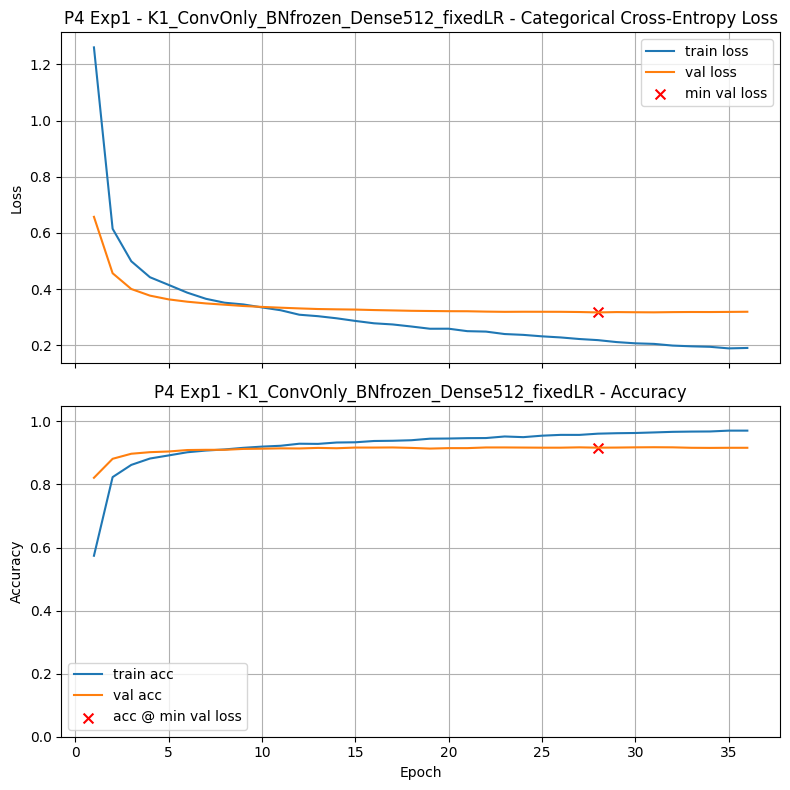

Final Training Loss:            0.1908
Final Training Accuracy:        0.9707
Final Validation Loss:          0.3197
Final Validation Accuracy:      0.9163
Validation Accuracy @ Min Loss: 0.9166

Test Loss: 0.3049
Test Accuracy: 0.9247

Validation-Test Gap (accuracy): 0.008030

Execution Time: 00:03:17

P4 Exp2 - K3_UnfreezeBN_Deep_ExpDecay

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.3173 - loss: 2.1544 - val_accuracy: 0.7756 - val_loss: 0.9316
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7343 - loss: 1.0573 - val_accuracy: 0.8115 - val_loss: 0.7940
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8374 - loss: 0.7990 - val_accuracy: 0.8315 - val_loss: 0.7575
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8704 - loss: 0.6989 - val_accuracy: 0.8465 - val_loss: 0.7220
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8843 - loss: 0.6582 - val_accuracy: 0.8725 - val_loss: 0.6772
Epoch 6/50
88/88 ━━

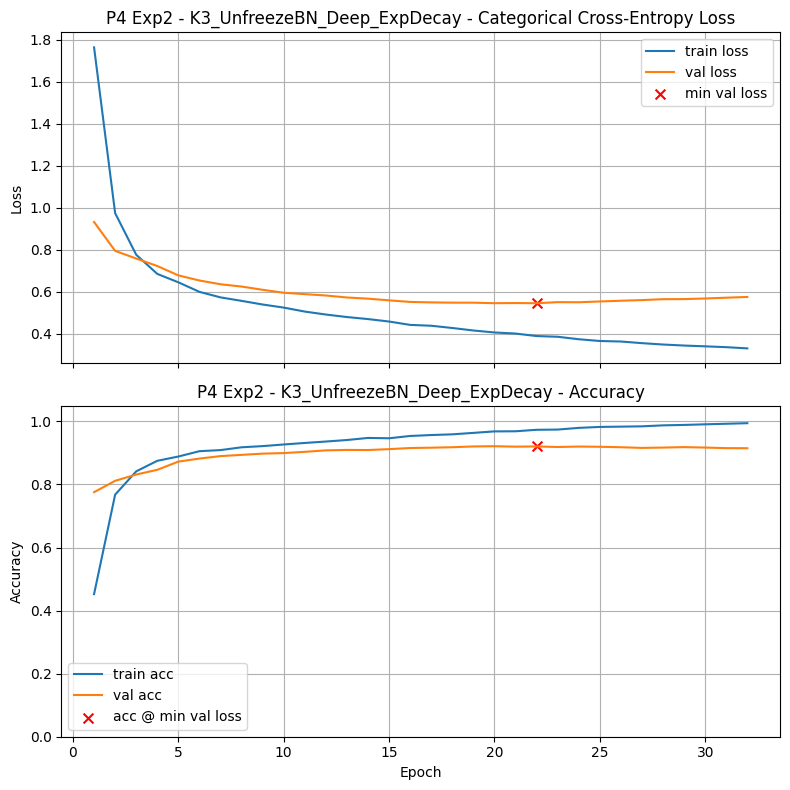

Final Training Loss:            0.3297
Final Training Accuracy:        0.9943
Final Validation Loss:          0.5746
Final Validation Accuracy:      0.9149
Validation Accuracy @ Min Loss: 0.9206

Test Loss: 0.5302
Test Accuracy: 0.9253

Validation-Test Gap (accuracy): 0.004778

Execution Time: 00:03:17

P4 Exp3 - K5_BNfrozen_Slim_CosineDecay

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - accuracy: 0.5119 - loss: 1.3907 - val_accuracy: 0.8507 - val_loss: 0.5511
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8686 - loss: 0.5417 - val_accuracy: 0.9052 - val_loss: 0.3729
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9011 - loss: 0.4334 - val_accuracy: 0.9141 - val_loss: 0.3384
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9161 - loss: 0.3753 - val_accuracy: 0.9177 - val_loss: 0.3240
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9248 - loss: 0.3457 - val_accuracy: 0.9216 - val_loss: 0.3127
Epoch 6/50
88/88 ━

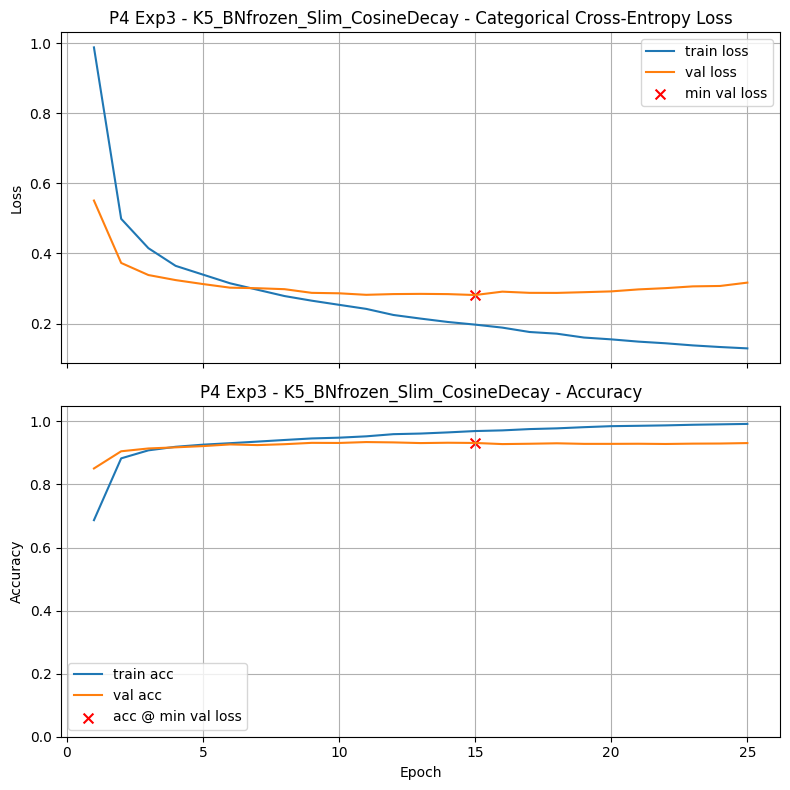

Final Training Loss:            0.1290
Final Training Accuracy:        0.9920
Final Validation Loss:          0.3168
Final Validation Accuracy:      0.9312
Validation Accuracy @ Min Loss: 0.9316

Test Loss: 0.2871
Test Accuracy: 0.9277

Validation-Test Gap (accuracy): 0.003933

Execution Time: 00:02:43

Problem 4 experiments finished. Summary (validation accuracy @ min val loss):
P4 Exp3 - K5_BNfrozen_Slim_CosineDecay  	0.9316	15
P3 Exp4 - N80_Slim_CosineDecay          	0.9270	22
P2 Exp3 - Dense256_128_CosineDecay_ft   	0.9206	20
P3 Exp1 - N20_Dense512_fixedLR          	0.9206	28
P4 Exp2 - K3_UnfreezeBN_Deep_ExpDecay   	0.9206	22
P3 Exp3 - N60_Deep_fixedLR              	0.9202	19
P3 Exp2 - N40_Deep_ExpDecay             	0.9198	20
Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR	0.9177	4
Problem1 Exp2 - Dense1024_512_ExpDecay  	0.9166	18
P4 Exp1 - K1_ConvOnly_BNfrozen_Dense512_fixedLR	0.9166	28
Problem1 Exp3 - Dense256_128_CosineDecay	0.9149	22
P2 Exp2 - Dense1024_512_ExpDecay_ft     	0.

In [40]:
# Your code here; add as many cells as you need


from math import ceil
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau

# -------------------------
# 1) Hyperparameters & LR schedules (change if needed)
# -------------------------
p4_epochs = 50                       # epoch budget (EarlyStopping usually stops earlier)
p4_batch_size = batch_size           # reuse global batch_size; lower if OOM (e.g., 64 or 32)
p4_initial_lr = 2e-5                 # small LR in the recommended range (1e-5 .. 3e-5)

# compute steps for decay schedules
steps_per_epoch_p4 = int(ceil(len(X_train) / p4_batch_size))
total_steps_p4 = p4_epochs * steps_per_epoch_p4

p4_exp_decay = ExponentialDecay(initial_learning_rate=p4_initial_lr,
                                decay_steps=total_steps_p4,
                                decay_rate=0.98,
                                staircase=False)

p4_cosine_decay = CosineDecay(initial_learning_rate=p4_initial_lr,
                              decay_steps=total_steps_p4,
                              alpha=0.0)

# ReduceLROnPlateau for these experiments (smaller patience since we're fine-tuning blocks)
reduce_lr_p4 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4,
                                 min_delta=1e-5, cooldown=0, min_lr=1e-8, verbose=1)

# -------------------------
# 2) Block prefixes: identifies the conv blocks (use exactly as instruction)
# -------------------------
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

# -------------------------
# 3) Helper: unfreeze top K blocks, optionally freeze BatchNorm layers
# -------------------------
def make_base_with_topK_unfrozen(K, unfreeze_bn=False):
    """
    Returns a MobileNetV2 base with only the top K *blocks* unfrozen.
    - K: how many block prefixes (from the end) to unfreeze (1..len(block_prefixes))
    - unfreeze_bn: if False, BatchNormalization layers remain frozen even if they are in the unfrozen blocks
    """
    # Start from a fresh backbone instance with trainable=False (per instructions)
    base = make_base_model_pooled(trainable=False)

    # Determine which block prefixes we will unfreeze: the last K prefixes
    # If K <= 0, nothing; if K >= len(block_prefixes), unfreeze everything by block name match.
    prefixes_to_unfreeze = block_prefixes[-K:] if K > 0 else []

    # For each layer, set layer.trainable based on whether its name starts with any chosen prefix
    for layer in base.layers:
        # If the layer is a BatchNormalization and we want BN frozen -> keep frozen
        if isinstance(layer, tf.keras.layers.BatchNormalization) and (not unfreeze_bn):
            layer.trainable = False
            continue

        # Check whether the layer name starts with any of the target prefixes
        should_unfreeze = any(layer.name.startswith(p) for p in prefixes_to_unfreeze)
        layer.trainable = bool(should_unfreeze)

    return base

# -------------------------
# 4) Build and run three experiments
#    - We vary K, BN behaviour, head, LR strategy, ReduceLROnPlateau usage, and EarlyStopping patience.
# -------------------------

# --- Experiment 1 ---
# K = 1 (unfreeze only the final "Conv_1" stage), keep BatchNorm frozen, simple head, fixed LR, ReduceLROnPlateau ON
title_p4_e1 = "P4 Exp1 - K1_ConvOnly_BNfrozen_Dense512_fixedLR"
K1 = 1
base_p4_e1 = make_base_with_topK_unfrozen(K1, unfreeze_bn=False)

model_p4_e1 = models.Sequential([
    base_p4_e1,                                           # MobileNetV2 backbone (most layers frozen)
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

hist_p4_e1 = train_and_test(
    model_p4_e1,
    epochs=p4_epochs,
    lr_schedule=p4_initial_lr,      # fixed small LR for Adam
    optimizer="Adam",
    title=title_p4_e1,
    batch_size=p4_batch_size,
    callbacks=[reduce_lr_p4],
    use_early_stopping=True,
    patience=8,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)


# --- Experiment 2 ---
# K = 3 (unfreeze last 3 blocks), UNFREEZE BatchNorm layers to test effect, deeper head, ExponentialDecay, ReduceLROnPlateau ON
title_p4_e2 = "P4 Exp2 - K3_UnfreezeBN_Deep_ExpDecay"
K2 = 3
base_p4_e2 = make_base_with_topK_unfrozen(K2, unfreeze_bn=True)

model_p4_e2 = models.Sequential([
    base_p4_e2,
    Dense(1024, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(512, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

hist_p4_e2 = train_and_test(
    model_p4_e2,
    epochs=p4_epochs,
    lr_schedule=p4_exp_decay,       # exponential decay schedule
    optimizer="Adam",
    title=title_p4_e2,
    batch_size=p4_batch_size,
    callbacks=[reduce_lr_p4],
    use_early_stopping=True,
    patience=10,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)


# --- Experiment 3 ---
# K = 5 (unfreeze last 5 blocks), keep BatchNorm frozen (often more stable), slim head, CosineDecay, no ReduceLROnPlateau
title_p4_e3 = "P4 Exp3 - K5_BNfrozen_Slim_CosineDecay"
K3 = 5
base_p4_e3 = make_base_with_topK_unfrozen(K3, unfreeze_bn=False)

model_p4_e3 = models.Sequential([
    base_p4_e3,
    Dense(256, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(128, activation=None, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

hist_p4_e3 = train_and_test(
    model_p4_e3,
    epochs=p4_epochs,
    lr_schedule=p4_cosine_decay,    # cosine decay schedule
    optimizer="Adam",
    title=title_p4_e3,
    batch_size=p4_batch_size,
    callbacks=[],                   # rely on cosine schedule + early stopping
    use_early_stopping=True,
    patience=10,
    min_delta=1e-5,
    verbose=1,
    return_history=True
)


# -------------------------
# 5) Summarize & choose best Problem 4 experiment
# -------------------------
print("\nProblem 4 experiments finished. Summary (validation accuracy @ min val loss):")
print_results()

# Filter only Problem 4 results (prefix "P4 ") so we pick best among these experiments
p4_results = {k: v for k, v in results.items() if k.startswith("P4")}
if len(p4_results) == 0:
    print("\nNo P4 results found in `results`. Did the cell run without errors?")
    # fallback to global best
    best_title_all, (best_acc_all, best_ep_all) = max(results.items(), key=lambda kv: kv[1][0])
    a4 = float(best_acc_all)
    print(f"Fallback: using global best {best_title_all} with val_acc = {a4:.4f}")
else:
    best_title_p4, (best_acc_p4, best_ep_p4) = max(p4_results.items(), key=lambda kv: kv[1][0])
    a4 = float(best_acc_p4)
    print(f"\nBest Problem 4 model: {best_title_p4}  val_acc = {a4:.4f}  (epoch {best_ep_p4})")

print(f"\na4 = {a4:.4f}   # copy this value into the graded cell if required")


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks.

**Your answer here:**




The best-performing setup was P4 Exp3 — K5_BNfrozen_Slim_CosineDecay, which achieved validation accuracy 0.9316. I designed the experiments to probe three axes: how many top conv blocks to unfreeze (K=1,3,5), whether to keep BatchNorm frozen, and which head capacity/LR strategy to pair with that (Dense512 fixed LR vs deeper Dense1024→512 with ExpDecay vs slim Dense256→128 with CosineDecay). The K=5 slim-head model likely won because unfreezing more blocks let the model adapt high-level convolutional features to the Intel scenes while keeping BatchNorm frozen preserved stable running statistics; simultaneously a compact, well-regularized head plus a smooth CosineDecay schedule reduced overfitting and produced steady convergence. This suggests that when you unfreeze several conv blocks, prioritize careful BN handling, conservative/decaying learning rates, and a smaller regularized head to get the most benefit from fine-tuning without destabilizing pretrained representations.




In [50]:
# Set a4 to the validation accuracy found by your best model for this problem.

a4 =  0.9316             # Replace 0.0 with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4 = {a4:.4f}')

a4 = 0.9316


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework.

This reflection question is worth 5 points.

In [43]:
# Print out summary of validation accuracy for each experiment

print_results()

P4 Exp3 - K5_BNfrozen_Slim_CosineDecay  	0.9316	15
P3 Exp4 - N80_Slim_CosineDecay          	0.9270	22
P2 Exp3 - Dense256_128_CosineDecay_ft   	0.9206	20
P3 Exp1 - N20_Dense512_fixedLR          	0.9206	28
P4 Exp2 - K3_UnfreezeBN_Deep_ExpDecay   	0.9206	22
P3 Exp3 - N60_Deep_fixedLR              	0.9202	19
P3 Exp2 - N40_Deep_ExpDecay             	0.9198	20
Problem1 Exp1 - Dense512_BN_Dropout0.5_ReduceLR	0.9177	4
Problem1 Exp2 - Dense1024_512_ExpDecay  	0.9166	18
P4 Exp1 - K1_ConvOnly_BNfrozen_Dense512_fixedLR	0.9166	28
Problem1 Exp3 - Dense256_128_CosineDecay	0.9149	22
P2 Exp2 - Dense1024_512_ExpDecay_ft     	0.9138	16
Model Baseline                          	0.9124	9
P2 Exp1 - Dense512_BN_Dropout0.5_ft_fixedLR	0.9116	16


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your answer here:**




## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

![Screenshot 2025-09-25 at 3.38.21 PM.png](attachment:2f17cb78-416f-4995-9eec-8b50c70dabf8.png)


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### TL;DR Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
